In [104]:
from copy import deepcopy
from PIL import Image
from numba import jit
import scipy.special as sc
import scipy.io
import imageio
import winsound
import tensorflow as tf # or Numba CUDA

%pylab
%matplotlib inline
style.use('default')
mpl.rcParams['figure.max_open_warning'] = False
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

Using matplotlib backend: QtAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


K:\Programs\Anaconda\envs\tf\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['psd', 'e', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [105]:
Nx = 10
Ny = 10
Nz = 10
Nmu = 4
radius_of_summation = 0

D = 1.41; J1 = 3.72; J2 = 0.0; J3a = 0.0; J3b = 0.0              # H_s Hertog and Gingras 2000       # D = (mu_0*mu**2)/(4*pi*rnn**3) #[J/m**3]  #mu = 10*mu_0 # J = -1.6 # -3.7 #[K] Davis  #mu_0 = 5.788381*10**-5 #[eV/T]
# D = 1.3224; J1 = 3.41; J2 = -0.14; J3a = 0.25; J3b = 0.025        # H_g
# D = 1.3224; J1 = 3.41; J2 = -0.14; J3a = 0.03; J3b = 0.031         # H_g+ Bramwell 2018
# D = 1.3224; J1 = 3.41; J2 = 0.006; J3a = -0.01416; J3b = 0.10216   # H_OP Samarakoon et al. 2020

N_alpha = np.array([Nx, Ny, Nz, Nmu])
N = Nx*Ny*Nz*Nmu                            # 4*8*8*8 ~ 2000
print(str(N)+" spins.")
a = 1.0                                     # Taking unit lattice spacing # 0.354*10**-9 #[m] = 0.354 nm
ann = sqrt(2*0.25**2) * a                   # This is the spacing between Ti ions # 0.35355339 * a
kB = 1.0 #[K/K]                             # Taking unit energy # kB = 8.617333*10**-5 #[eV/K]

e = 2.71828182846
alpha = 1.0
r0 = 1.0
L = Nx*a

state_rnd  = zeros((Nx,Ny,Nz,Nmu), dtype=int8)
state_2i2o  = ones((Nx,Ny,Nz,Nmu), dtype=int8)
realspace  = zeros((Nx,Ny,Nz,Nmu,3), dtype=float)
spin_orient = zeros((Nx,Ny,Nz,Nmu,3), dtype=float)
lattice    = zeros((Nx,Ny,Nz,3), dtype=float)

# Lattice Vectors
l0 = array([0.0, 0.0, 0.0]);     l1 = array([0, 0.5*a, 0.5*a]);
l2 = array([0.5*a, 0.0, 0.5*a]); l3 = array([0.5*a, 0.5*a, 0.0]);
l = array([l0, l1, l2, l3])

# Basis Vectors
d0 = array([0.0, 0.0, 0.0]);      d1 = array([0.0, 0.25, 0.25]);
d2 = array([0.25, 0.0, 0.25]);    d3 = array([0.25, 0.25, 0.0]);
basis_vectors = array([d0, d1, d2, d3])

# Reciprocal Lattice Vectors
k0 = array([0, 0, 0]);             k1 = (2*pi)*cross(l2, l3)/dot(l1,cross(l2,l3));
k2 = (2*pi)*cross(l3, l1)/dot(l2,cross(l3,l1));         k3 = (2*pi)*cross(l1, l2)/dot(l3,cross(l1,l2));

# Local Spin Reference Vectors (Unit vectors pointing out of the tetrahedron along the local <111> direction, ui.uj = -1/3
u0 = (3**-0.5)*array([-1.0, -1.0, -1.0]);    u1 = (3**-0.5)*array([-1.0, 1.0, 1.0]);
u2 = (3**-0.5)*array([1.0, -1.0, 1.0]);   u3 = (3**-0.5)*array([1.0, 1.0, -1.0]);
local_axis = array([u0, u1, u2, u3])

for x in arange(0, Nx):
    for y in arange(0, Ny):
        for z in arange(0, Nz):
            lattice[x, y, z, :]   = x*l[1] + y*l[2] + z*l[3]
            state_rnd[x, y, z, :] = (-1)**randint(100), (-1)**randint(100), (-1)**randint(100), (-1)**randint(100)
            for mu in arange(0,Nmu):
                realspace[x, y, z, mu, :] = lattice[x, y, z, :] + basis_vectors[mu]
                spin_orient[x, y, z, mu, :] = local_axis[mu] # used for plotting
                state_2i2o[x,y,z,mu] = (-1)**mu

4000 spins.


In [106]:
# Build Replica translation vectors for Ewald summation
A = array([Nx*l1, Ny*l2, Nz*l3])
B = array([Nx*k1, Ny*k2, Nz*k3])
V = dot(A[0],cross(A[1],A[2]))
replica_int = []
replica_r = []
replica_k = []
replica_index = []
replica_rnn = []

for i in arange(-radius_of_summation, radius_of_summation+1):
    for j in arange(-radius_of_summation, radius_of_summation+1):
        for k in arange(-radius_of_summation, radius_of_summation+1):
            if sqrt(i**2 + j**2 + k**2) <= radius_of_summation:
                replica_int.append(array([i, j, k]))
                replica_r.append(i*A[0] + j*A[1] + k*A[2])
                replica_k.append(i*B[0] + j*B[1] + k*B[2])
                if sqrt(i**2 + j**2 + k**2) <= sqrt(3): # Nearest replicas only
                    replica_index.append((2*(i*A[0] + j*A[1] + k*A[2])).astype(int))
                    replica_rnn.append(i*A[0] + j*A[1] + k*A[2])
replica_int = array(replica_int); replica_r = array(replica_r); replica_k = array(replica_k); replica_index = array(replica_index); replica_rnn = array(replica_rnn);
Nr = replica_int.shape[0]; print(Nr);
Nrnn = replica_rnn.shape[0]

def Baux(r):
    return (1/r**3)*(scipy.special.erfc(alpha*r) + (2*alpha*r/sqrt(pi))*(e**(-2*(alpha**2)*(r**2))))

def Caux(r):
    return (1/r**5)*(3*scipy.special.erfc(alpha*r) + (2*alpha*r/sqrt(pi))*(e**(-2*(alpha**2)*(r**2)))*(3+2*(alpha**2)*(r**2)))

1


In [107]:
try:
#     Si0Sj0 = load("K:/code/spin ice/interaction matrices/Si0Sj0_"+str(Nx)+str(Ny)+str(Nz)+".npy")
#     rijdist = load("K:/code/spin ice/interaction matrices/rijdist_"+str(Nx)+str(Ny)+str(Nz)+".npy")
    rij = load("K:/code/spin ice/interaction matrices/rij_"+str(Nx)+str(Ny)+str(Nz)+".npy")
except:
    Si0Sj0 = zeros((Nx,Ny,Nz,Nmu,Nx,Ny,Nz,Nmu))
    rijdist = zeros((Nx,Ny,Nz,Nmu,Nx,Ny,Nz,Nmu)) # For checking distance distribution # zeros((Nx,Ny,Nz,Nmu,Nx,Ny,Nz,Nmu)) # Initializing as zeros may be a problem
    rij = zeros((Nx,Ny,Nz,Nmu,Nx,Ny,Nz,Nmu,3))   # Identities are zero

    for xi in arange(0,Nx):
        print(xi/Nx)
        for yi in arange(0,Ny):
            for zi in arange(0,Nz):
                for mui in arange(0,Nmu):

                    for xj in arange(0,Nx):
                        for yj in arange(0,Ny):
                            for zj in arange(0,Nz):
                                for muj in arange(0,Nmu):

                                    if not (xi == xj and yi == yj and zi == zj and mui == muj):  #If not-self interaction
                                        Si0Sj0[xi,yi,zi,mui,xj,yj,zj,muj] = dot(local_axis[mui],local_axis[muj])

                                        ri = realspace[xi,yi,zi,mui,:]          #Unpack real space location vector
                                        rj = realspace[xj,yj,zj,muj,:]

                                        rij[xi,yi,zi,mui,xj,yj,zj,muj,:] = rj-ri
                                        rijdist[xi,yi,zi,mui,xj,yj,zj,muj] = dot(rj-ri,rj-ri)**0.5
    save("K:/code/spin ice/interaction matrices/Si0Sj0_"+str(Nx)+str(Ny)+str(Nz)+".npy", Si0Sj0)
    save("K:/code/spin ice/interaction matrices/rijdist_"+str(Nx)+str(Ny)+str(Nz)+".npy", rijdist)
    save("K:/code/spin ice/interaction matrices/rij_"+str(Nx)+str(Ny)+str(Nz)+".npy", rij)

try:
    if radius_of_summation == 0:
        eta = (J1*load("K:/code/spin ice/interaction matrices/eta_J1_"+str(Nx)+str(Ny)+str(Nz)+"_r"+str(radius_of_summation)+".npy") +
               J2*load("K:/code/spin ice/interaction matrices/eta_J2_"+str(Nx)+str(Ny)+str(Nz)+"_r"+str(radius_of_summation)+".npy") +
               J3a*load("K:/code/spin ice/interaction matrices/eta_J3a_"+str(Nx)+str(Ny)+str(Nz)+"_r"+str(radius_of_summation)+".npy") +
               J3b*load("K:/code/spin ice/interaction matrices/eta_J3b_"+str(Nx)+str(Ny)+str(Nz)+"_r"+str(radius_of_summation)+".npy"))
        eta_J1 = load("K:/code/spin ice/interaction matrices/eta_J1_"+str(Nx)+str(Ny)+str(Nz)+"_r0.npy")
    else:
        eta = (J1*load("K:/code/spin ice/interaction matrices/eta_J1_"+str(Nx)+str(Ny)+str(Nz)+".npy") +
               J2*load("K:/code/spin ice/interaction matrices/eta_J2_"+str(Nx)+str(Ny)+str(Nz)+".npy") +
               J3a*load("K:/code/spin ice/interaction matrices/eta_J3a_"+str(Nx)+str(Ny)+str(Nz)+".npy") +
               J3b*load("K:/code/spin ice/interaction matrices/eta_J3b_"+str(Nx)+str(Ny)+str(Nz)+".npy")) 
        eta_J1 = load("K:/code/spin ice/interaction matrices/eta_J1_"+str(Nx)+str(Ny)+str(Nz)+".npy")
except:
    nn = np.zeros((Nx,Ny,Nz,Nmu,Nx,Ny,Nz,Nmu), dtype = int8)
    nnn = np.zeros((Nx,Ny,Nz,Nmu,Nx,Ny,Nz,Nmu), dtype = int8)
    nnnna = np.zeros((Nx,Ny,Nz,Nmu,Nx,Ny,Nz,Nmu), dtype = int8)
    nnnnb = np.zeros((Nx,Ny,Nz,Nmu,Nx,Ny,Nz,Nmu), dtype = int8)
    eta_J1 = zeros((Nx,Ny,Nz,Nmu,Nx,Ny,Nz,Nmu))
    eta_J2 = zeros((Nx,Ny,Nz,Nmu,Nx,Ny,Nz,Nmu))
    eta_J3a = zeros((Nx,Ny,Nz,Nmu,Nx,Ny,Nz,Nmu))
    eta_J3b = zeros((Nx,Ny,Nz,Nmu,Nx,Ny,Nz,Nmu))
#     rij = rij.tolist(); replica_rnn = replica_rnn.tolist();
    for n in arange(0, Nrnn):
        print("n1", n/Nrnn)
        for xi in arange(0, Nx):
            for yi in arange(0, Ny):
                for zi in arange(0, Nz):
                    for mui in arange(0, Nmu):
                        for xj in arange(0, Nx):
                            for yj in arange(0, Ny):
                                for zj in arange(0, Nz):
                                    for muj in arange(0, Nmu):
                                        if ann == dot(rij[xi,yi,zi,mui,xj,yj,zj,muj]+replica_rnn[n], rij[xi,yi,zi,mui,xj,yj,zj,muj]+replica_rnn[n])**0.5:
                                            eta_J1[xi,yi,zi,mui, xj,yj,zj,muj] = dot(local_axis[mui], local_axis[muj])
                                            nn[xi,yi,zi,mui, xj,yj,zj,muj] = 1
    time0 = time.time()
    for xi, yi, zi, mui, xj, yj, zj, muj in list(zip(*where(nn==1))):
        for x2, y2, z2, mu2 in list(zip(*where(nn[xi,yi,zi,mui,:,:,:,:]==0))):
            for n2 in arange(0, Nrnn):
                rplusn = dot(rij[xj,yj,zj,muj,x2,y2,z2,mu2]+replica_rnn[n2],rij[xj,yj,zj,muj,x2,y2,z2,mu2]+replica_rnn[n2])**0.5
                if rplusn == ann and mui == mu2 and (xi!=x2 or yi!=y2 or zi!=z2):
                    eta_J3a[xi,yi,zi,mui, x2,y2,z2,mu2] = dot(local_axis[mui], local_axis[mu2])
                    nnnna[xi,yi,zi,mui, x2,y2,z2,mu2] = 1
                elif rplusn == ann and mui != mu2:
                    eta_J2[xi,yi,zi,mui, x2,y2,z2,mu2] = dot(local_axis[mui], local_axis[mu2])
                    nnn[xi,yi,zi,mui, x2,y2,z2,mu2] = 1

    print(time.time() - time0)
    time0 = time.time()    
    for xi, yi, zi, mui, x2, y2, z2, mu2 in list(zip(*where(nnn==1))):
        for x3,y3,z3,mu3 in list(zip(*where((nnn[xi,yi,zi,mui,:,:,:,:]==0) & (nnnna[xi,yi,zi,mui,:,:,:,:]==0)))):
            for n3 in arange(0, Nrnn):
                rplusn = dot(rij[x2,y2,z2,mu2,x3,y3,z3,mu3]+replica_rnn[n3], rij[x2,y2,z2,mu2,x3,y3,z3,mu3]+replica_rnn[n3])**0.5
                if rplusn == ann and mui == mu3 and (xi!=x3 or yi!=y3 or zi!=z3):
                    eta_J3b[xi,yi,zi,mui, x3,y3,z3,mu3] = dot(local_axis[mui], local_axis[mu3])
                    nnnnb[xi,yi,zi,mui, x3,y3,z3,mu3] = 1
    print(time.time() - time0)

#     nn = array(nn)#; nnn = nnn.toarray();                                                            
    print("First NN: ", Nx*Ny*Nz*Nmu*6, sum(nn.reshape(-1)))
    print("Second NN: ", Nx*Ny*Nz*Nmu*6*2, sum(nnn.reshape(-1)))
    print("Third-a NN: ", Nx*Ny*Nz*Nmu*6, sum(nnnna.reshape(-1)))
    print("Third-b NN: ", Nx*Ny*Nz*Nmu*6, sum(nnnnb.reshape(-1)))
    
    if radius_of_summation == 0:
        save("K:/code/spin ice/interaction matrices/eta_J1_"+str(Nx)+str(Ny)+str(Nz)+"_r"+str(radius_of_summation)+".npy", eta_J1)
        save("K:/code/spin ice/interaction matrices/eta_J2_"+str(Nx)+str(Ny)+str(Nz)+"_r"+str(radius_of_summation)+".npy", eta_J2)
        save("K:/code/spin ice/interaction matrices/eta_J3a_"+str(Nx)+str(Ny)+str(Nz)+"_r"+str(radius_of_summation)+".npy", eta_J3a)
        save("K:/code/spin ice/interaction matrices/eta_J3b_"+str(Nx)+str(Ny)+str(Nz)+"_r"+str(radius_of_summation)+".npy", eta_J3b)
    else:
        save("K:/code/spin ice/interaction matrices/eta_J1_"+str(Nx)+str(Ny)+str(Nz)+".npy", eta_J1)
        save("K:/code/spin ice/interaction matrices/eta_J2_"+str(Nx)+str(Ny)+str(Nz)+".npy", eta_J2)
        save("K:/code/spin ice/interaction matrices/eta_J3a_"+str(Nx)+str(Ny)+str(Nz)+".npy", eta_J3a)
        save("K:/code/spin ice/interaction matrices/eta_J3b_"+str(Nx)+str(Ny)+str(Nz)+".npy", eta_J3b)
    eta = J1*eta_J1 + J2*eta_J2 + J3a*eta_J3a + J3b*eta_J3b
    
try:
    eta += D*(ann**3)*load("K:/code/spin ice/interaction matrices/eta_D_"+str(Nx)+str(Ny)+str(Nz)+"_r"+str(radius_of_summation)+".npy")
except:
    time0 = time.time()
    eta_D = zeros((Nx,Ny,Nz,Nmu,Nx,Ny,Nz,Nmu))
    # Ewald Summation (Following Yee2016 and Holm2001)
    # Sum over replicas
    for n in arange(0, Nr):
        print("D", str(round(100*n/Nr,3))+"%")
        # Reciprocal Space
        if not (replica_k[n][0]==0 and replica_k[n][1]==0 and replica_k[n][2]==0):
            recip_coef = (1/(2*L**3)) * (4*pi/dot(replica_k[n],replica_k[n])) * e**(-(pi**2) *dot(replica_k[n],replica_k[n])/((L*alpha)**2))
        # Sum over all dipole pairs
        for xi in arange(0, Nx):
            for yi in arange(0, Ny):
                for zi in arange(0, Nz):
                    for mui in arange(0, Nmu):
                        # Self-Interaction Correction
                        if n == 0: # Calculate once
                            eta_D[xi,yi,zi,mui,xi,yi,zi,mui] -= ((2*alpha**3)/(3*sqrt(pi)))*dot(local_axis[mui],local_axis[mui])
                        for xj in arange(0, Nx):
                            for yj in arange(0, Ny):
                                for zj in arange(0, Nz):
                                    for muj in arange(0, Nmu):
                                        # Real Space
                                        rij_ = rij[xi,yi,zi,mui,xj,yj,zj,muj,:]
                                        rplusn = dot(rij_+replica_r[n], rij_+replica_r[n])**0.5
                                        if not ((replica_r[n][0]==0 and replica_r[n][1]==0 and replica_r[n][2]==0) and (xi==xj and yi==yj and zi==zj and mui==muj) and rplusn == 0):
                                            eta_D[xi,yi,zi,mui,xj,yj,zj,muj] += (1/2)* (dot(local_axis[mui], local_axis[muj]) * Baux(rplusn) - dot(local_axis[mui],(rij_+replica_r[n])) * dot(local_axis[muj],(rij_+replica_r[n])) * Caux(rplusn))
                                        # Reciprocal Space
                                        if not (replica_k[n][0]==0 and replica_k[n][1]==0 and replica_k[n][2]==0):
                                            eta_D[xi,yi,zi,mui,xj,yj,zj,muj] += recip_coef * dot(local_axis[mui],replica_k[n])*dot(local_axis[muj],replica_k[n]) * e**(cos(dot(replica_k[n],rij_)/L))
    print(time.time() - time0)
    save("K:/code/spin ice/interaction matrices/eta_D_"+str(Nx)+str(Ny)+str(Nz)+"_r"+str(radius_of_summation)+".npy", eta_D)
    eta += D*(ann**3)*eta_D

In [108]:
@jit
def calc_energy(state):
    energy = 0.0
    for xi in arange(0,Nx):
        for yi in arange(0,Ny):
            for zi in arange(0,Nz):
                for mui in arange(0,Nmu):
                    sigma_i = state[xi,yi,zi,mui]
                    for xj in arange(0,Nx):
                        for yj in arange(0,Ny):
                            for zj in arange(0,Nz):
                                for muj in arange(0,Nmu):
                                    if not (xi == xj and yi == yj and zi == zj and mui == muj):  #If not-self interaction
                                        if (xi+yi*Nx+zi*Nx*Ny+mui*Nx*Ny*Nz < xj+yj*Nx+zj*Nx*Ny+muj*Nx*Ny*Nz):   #Restricted against double-counting
                                            energy += eta[xi,yi,zi,mui, xj,yj,zj,muj]*sigma_i*state[xj,yj,zj,muj]
    return energy

# @jit
# def calc_energy_np(state): # Needs benchmarking
#     energy = np.tensordot(np.tensordot(eta,state,[[4,5,6,7],[0,1,2,3]]),state, [[0,1,2,3],[0,1,2,3]])
#     energy -= N*eta[xi,yi,zi,mui,xi,yi,zi,mui]     # Subtract self-interaction
#     energy /= 2.0
#     return energy

@jit
def calc_energy_dif(xi, yi, zi, mui, state):
    energy = np.sum(np.multiply(eta[xi,yi,zi,mui,:,:,:,:], state[:,:,:,:]))*state[xi,yi,zi,mui]
    energy -= eta[xi,yi,zi,mui,xi,yi,zi,mui]     # Subtract self-interaction
    return -2*energy

In [109]:
#A simple progress bar.
def echo(string, padding=160):
    padding = " " * (padding - len(string)) if padding else ""
    print(string + padding, end='\r')   
def progress(t, T, time0):
    block_number = int(round(50*t/T))
    bar_string = "|"
    for n in arange(0,50):
        if n < block_number:
            bar_string = bar_string + "#"
        else:
            bar_string = bar_string + " "
    time1 = time.time()
    if block_number != 0:
        seconds = ((50/block_number)-1)*(time1-time0)
        minutes = seconds // 60
        hours = minutes // 60
        minutes -= hours*60
        seconds -= (minutes*60 + hours*3600)
        if minutes == 0 and hours == 0:
            bar_string = bar_string + "| " + str(int(round(100*t/T))) + "% (" + str(round(seconds)) + " seconds remaining)"
        elif minutes != 0 and hours == 0:
            bar_string = bar_string + "| " + str(int(round(100*t/T))) + "% (" + str(round(minutes)) + " minutes and " + str(round(seconds)) + " seconds remaining)"
        else:
            bar_string = bar_string + "| " + str(int(round(100*t/T))) + "% (" + str(round(hours)) + " hours " + str(round(minutes)) + " minutes and " + str(round(seconds)) + " seconds remaining)"
    else:
        bar_string = bar_string + "| " + str(int(round(100*t/T))) + "%"
    echo(bar_string)

def dif(A, B):
    return len(array(where(A != B))[0].reshape(-1))
def is_same(A, B):
    if dif(A, B) == 0:
        return True
    else:
        return False
    
def add_mu(ijkm, mu):
    if mu > 0:
        if ijkm[3] == 0:
            ijkm[3] = mu
        else:
            ijkm[mu-1] += 1
            ijkm[3] = 0
    elif mu < 0:
        mu = abs(mu)
        if ijkm[3] == 0:
            ijkm[mu-1] -= 1
            ijkm[3] = mu
        else:
            ijkm[3] = 0
    return ijkm

def nutoi(nu):
    mu = int((nu) // (Nx*Ny*Nz))
    z = int((nu - mu*Nx*Ny*Nz) // (Nx*Ny))
    y = int((nu - z*Nx*Ny - mu*Nx*Ny*Nz) // (Nx))
    x = int((nu - y*Nx - z*Nx*Ny - mu*Nx*Ny*Nz) // (1))
    return array([x, y, z, mu])

def itonu(i,j,k,mu):
    return i + j*Nx + k*Nx*Ny + mu*Nx*Ny*Nz

@jit
def calc_mag(states_temp, mag):
    for i in arange(0, Nx):
        for j in arange(0, Ny):
            for k in arange(0, Nz):
                mag[:,0] += states_temp[:, i,j,k,0]*local_axis[0,0] + states_temp[:, i,j,k,1]*local_axis[1,0] + states_temp[:, i,j,k,2]*local_axis[2,0] + states_temp[:, i,j,k,3]*local_axis[3,0]
                mag[:,1] += states_temp[:, i,j,k,0]*local_axis[0,1] + states_temp[:, i,j,k,1]*local_axis[1,1] + states_temp[:, i,j,k,2]*local_axis[2,1] + states_temp[:, i,j,k,3]*local_axis[3,1]
                mag[:,2] += states_temp[:, i,j,k,0]*local_axis[0,2] + states_temp[:, i,j,k,1]*local_axis[1,2] + states_temp[:, i,j,k,2]*local_axis[2,2] + states_temp[:, i,j,k,3]*local_axis[3,2]
    return mag

@jit
def find_monopoles(state):
    charges = []
    locations = []
    index = []
    for i in range(Nx):
        for j in range(Ny):
            for k in range(Nz):
                # Explicit Tetrahedra
                net = sum(state[i,j,k,:].reshape(-1))
                if net != 0:
                    charges.append(net)
                    locations.append(lattice[i,j,k,:] + array([1/8, 1/8, 1/8]))
                    index.append(np.array([i, j, k]))
                
                # Implicit Tetrahedra
                net = -1*(state[i,j,k,0] + state[i-1,j,k,1] + state[i,j-1,k,2] + state[i,j,k-1,3])
                if net != 0:
                    charges.append(net)
                    locations.append((lattice[i,j,k,:] + lattice[i-1,j,k,:] + lattice[i,j-1,k,:] + lattice[i,j,k-1,:])/4.0 + array([1/8, 1/8, 1/8]))
                    index.append(-1.0*np.array([i, j, k]))
                
    return charges, np.array(locations), index

@jit
def calc_monopole_population(state):
    counts_by_category = np.zeros(5, dtype=int) # -4, -2, 0, +2, +4 or AI, 3I, 2I2O, 3O, AO
    vals = array([-4, -2, 0, +2, +4])
    for i in range(Nx):
        for j in range(Ny):
            for k in range(Nz):
                # Explicit Tetrahedra
                net = sum(state[i,j,k,:].reshape(-1))
                for n in range(5):
                    if net == vals[n]:
                        arg = n
                counts_by_category[arg] += 1
                
                # Implicit Tetrahedra
                net = -1*(state[i,j,k,0] + state[i-1,j,k,1] + state[i,j-1,k,2] + state[i,j,k-1,3])
                for n in range(5):
                    if net == vals[n]:
                        arg = n
                counts_by_category[arg] += 1
                
    return counts_by_category

@jit
def flatten_state(state):
    flat_state = np.zeros(Nx*Ny*Nz*Nmu)
    for j in range(Ny):
        for k in range(Nz):
            for mu in range(Nmu):
                flat_state[j*Nx+k*Nx*Ny+mu*Nx*Ny*Nz : j*Nx+k*Nx*Ny+mu*Nx*Ny*Nz + Nx] = state[:,j,k,mu]
    return flat_state

@jit
def calc_labels():
    labels = zeros(Nx*Ny*Nz*Nmu, dtype=int)
    for i in arange(0, Nx):
        for j in arange(0, Ny):
            for k in arange(0, Nz):
                for mu in arange(0,Nmu):
                    labels[i+j*Nx+k*Nx*Ny+mu*Nx*Ny*Nz] = i+j*Nx+k*Nx*Ny+mu*Nx*Ny*Nz
    return labels

@jit
def calc_rates(state_temp, T_temp):
    energy_dim = -2*np.multiply(state_temp[:,:,:,:], np.tensordot(eta[:,:,:,:, :,:,:,:], state_temp[:,:,:,:], [[4,5,6,7],[0,1,2,3]]))
    energy_dim -= -2*eta[1,1,1,1, 1,1,1,1]*np.ones((Nx,Ny,Nz,Nmu)) # Subtract self-interaction, a constant
    rates_dim = np.exp(-(energy_dim/(kB*T_temp)))
    return rates_dim

@jit
def calc_effective_field(state):
    effective_field = np.zeros((Nx, Ny, Nz, Nmu, 3))
    for xi, yi, zi, mui, xj, yj, zj, muj in list(zip(*where(eta_J1!=0))):
        effective_field[xi,yi,zi,mui, :] += state[xj,yj,zj,muj]*local_axis[muj]
    return effective_field

@jit
def rates_mask(rates, state, threshold = 0.0):
    h = calc_effective_field(state)
    h = np.cross(local_axis, h, 1, 4)
    h = sum(multiply(h, h), 4)**0.5
    return where(h > threshold, rates, 0)

#@jit
def select_state(rfloat, rates_n, labels):
    if rfloat <= rates_n[0]:
        nu1 = labels[0]
    for nu in arange(1, Nx*Ny*Nz*Nmu):
        if (rates_n[nu-1] < rfloat) and (rfloat <= rates_n[nu]):
            nu1 = labels[nu]
    return nu1

#@jit
def loopstep(loc, state):
    # Initialize Loop
    nu1 = itonu(loc[0], loc[1], loc[2], loc[3])
    nu_previous = deepcopy(nu1)
    loc1 = deepcopy(loc)
    sigma1 = state[loc1[0],loc1[1],loc1[2],loc1[3]]
    loop = [ nu1 ]
    looping = True
    
    # Determine which tetrahedron to begin with; will alternate henceforth to ensure only two spins per tetrahedron are flipped.
    sign = (-1)**randint(0,2) # This is the truth value of xi==xj and yi==yj and zi==zj.
    
    while looping == True:
        try:
#             print(nu1)
            # Gather valid neighboring spins
            valid_spins_ = []
            for nu in arange(0, N): # Run over lattice index.
                if nns[nu1, nu] != 0: # Check for nearest neighbor.
#                     print("nearest neighbor")
                    loc_ = nutoi(nu)
                    if ((sign > 0 and loc1[0]==loc_[0] and loc1[1]==loc_[1] and loc1[2]==loc_[2]) or 
                        (sign < 0 and loc1[0]!=loc_[0] and loc1[1]!=loc_[1] and loc1[2]!=loc_[2])): # Check tetrahedra type.
                        if sigma1 != state[loc_[0],loc_[1],loc_[2],loc_[3]]: # Check for opposite spin.
#                             print("opposite sign")
                            if nu != nu_previous: # Check not previous spin. Alternating sign might already do this.
#                                 print("not previous")
                                valid_spins_.append(nu)
#                             else:
#                                 print("previous spin")
#                         else:
#                             print("not opposite sign")
#                     else:
#                         print("no valid tetrahedra")
                else:
                    0
#                     print("not nearest neighbor")
#             print(valid_spins_)

            # Select the next spin in the loop.
            nu_previous = deepcopy(nu1)
            nu1 = array(valid_spins_)[ randint(0,len(valid_spins_)) ]

            # Reassign spin value
            loc1 = nutoi(nu1)
            sigma1 = state[loc1[0],loc1[1],loc1[2],loc1[3]]

            # Alternate tetrahedron sign
            sign *= -1

            # Append the loop / Terminate the loop ... What is a more robust way to do this?
            if nu1 in loop:
#                 print("End loop: nu1 = " + str(nu1))
                looping = False
            else:
                loop.append(nu1)
        except:
            if valid_spins_ == []:
                return state
#                 print("No valid loop.")
#     print(loop)
    
    state_output = deepcopy(state)
    # Remove non-loop spins and Flip the loop.
    loop_start = False
    for nu in array(loop):
#         print(nu)
        if nu == nu1:
#             print("nu == nu1")
            loop_start = True
        if loop_start == True:
#             print("flip " + str(nu))
            loc = nutoi(nu)
#             print(loc)
            state_output[loc[0],loc[1],loc[2],loc[3]] *= -1
    
    return state_output

def mmc(state = ones((Nx,Ny,Nz,Nmu)), Nn = 1000, T = zeros(1000), loops = True): # Add T array functionality (Epoch, Series)
    Energy = calc_energy(state); print(Energy);

    states = zeros((Nn+1,Nx,Ny,Nz,Nmu),dtype=int); states[0, :,:,:,:] = deepcopy(state);
    energies = zeros((Nn+1));                      energies[0] = deepcopy(Energy);
    energy_sampling = []

    n = 0

    time0 = time.time() #Initial Time for Progress Bar

    # Initialize last_spin outside of bounds
    last_spin = itonu(Nx, Ny, Nz, Nmu)

    while n < Nn:
        # Build a trial state by flipping a random spin
        state_trial = deepcopy(states[n, :,:,:,:])
        x1, y1, z1, mu1 = randint(0,Nx), randint(0,Ny), randint(0,Nz), randint(0, Nmu)
        
        # If spin was just flipped, flip a loop
        if last_spin == itonu(x1, y1, z1, mu1) and loops == True:
            state_trial[x1, y1, z1, mu1] *= -1 #Flip the Spin Back
            state_loop = loopstep(array([x1, y1, z1, mu1]), deepcopy(state_trial[:,:,:,:]))
            if not is_same(state_loop, states[n, :,:,:,:]):
                state_trial = deepcopy(state_loop)
#                 print("Loop Flip")
        # Else flip the spin
        else:
            state_trial[x1, y1, z1, mu1] *= -1 #Flip the Trial Spin
            last_spin = itonu(x1, y1, z1, mu1)
        
        E_trial = energies[n] + calc_energy_dif(array([x1, y1,z1,mu1]), deepcopy(states[n]))

        if T[n] == 0.0 and E_trial <= Energy:
            Energy = deepcopy(E_trial)
            energies[n+1] = deepcopy(E_trial)
            states[n+1, :,:,:,:] = deepcopy(state_trial)
            n += 1

        elif (E_trial-Energy <= 0) or (2.71828**-((E_trial-Energy)/(kB*T[n])) > rand()):
#             print(str(Energy) +" to "+ str(E_trial))
#             print(str(2.71828**-((E_trial-Energy)/(kB*T[n]))) +" vs "+ str(rand()))
            Energy = deepcopy(E_trial);
            energies[n+1] = deepcopy(E_trial)
            states[n+1, :,:,:,:] = deepcopy(state_trial)
            progress(n, Nn, time0)   #Progress bar
            n += 1
        energy_sampling.append(deepcopy(Energy))
    print("System Energy: " + str(Energy))
    return states, array(energy_sampling)

#@ don't jit
def kmc(state = state_rnd, Nn = 100000, T = np.ones(100000), mode="normal"):#, recurrent=False):
    time0 = time.time(); N10 = int(round(Nn/10));  # Initialize Progress Reporting
    states = zeros((Nn+1, Nx, Ny, Nz, Nmu), dtype=int8)
    energies = zeros(Nn+1); energies[0] = calc_energy(state);
    times = zeros(Nn+1)
    labels0 = calc_labels()
    states[0,:,:,:,:] = deepcopy(state);
    
    for n in arange(0, Nn):
        if n % N10 == 0:
            if n != 0:
                print((Nn-n)*(time.time()-time0)/N10,"seconds left.")
            time0 = time.time()
        if mode == "two-rate":
            rates_n = flatten_state(rates_mask(calc_rates(states[n, :,:,:,:], T[n]), states[n, :,:,:,:]))
        else:
            rates_n = flatten_state(calc_rates(states[n, :,:,:,:], T[n]))
        
        labels = deepcopy(labels0)
        rates_n, labels = zip(*sorted(zip(rates_n, labels)))
        rates_n = np.cumsum(rates_n)
        Qk = rates_n[-1]
        
        loc1 = nutoi( labels[ where((random.rand()*Qk <= rates_n) )[0][0] ] )
        x, y, z, mu = loc1[0], loc1[1], loc1[2], loc1[3]
        E_dif = calc_energy_dif(x, y, z, mu, states[n,:,:,:,:])
        
        dt = (Qk**-1)*log(1/random.rand())
        times[n+1] = times[n] + dt
        
        states[n+1,:,:,:,:] = states[n,:,:,:,:]
        states[n+1,x,y,z,mu] *= -1
        energies[n+1] = energies[n] + E_dif
        
    times /= mean(times[1:]-times[:-1])
    times *= 83*10**-6
    print("Final System Energy: " + str(energies[n]))
    return states, energies, times

def step(s, s0 = 0, sf = 1.0):
    if s < s0 or s >= sf:
        output = 0.0
    else:
        output = 1.0
    return output

In [110]:
states = (2.0*(np.random.randint(0,2,(1000,Nx,Ny,Nz,Nmu)) - 0.5)).astype(int8)

5.215600490570068 seconds left.
4.715000152587891 seconds left.
4.353225469589233 seconds left.
3.1302037239074707 seconds left.
2.529383897781372 seconds left.
2.0486106872558594 seconds left.
1.4422402381896973 seconds left.
1.086599349975586 seconds left.
0.5693469047546387 seconds left.
Final System Energy: -142.50590498042416
That took 6.2164223194122314 seconds.


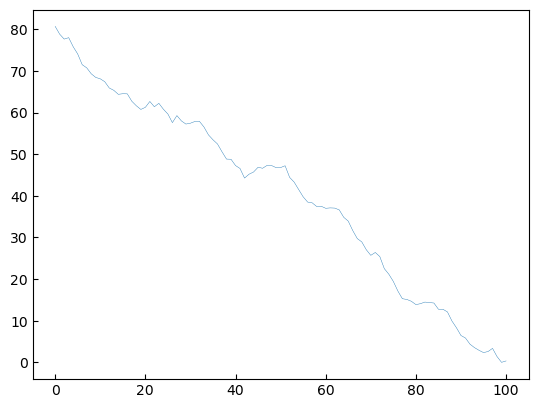

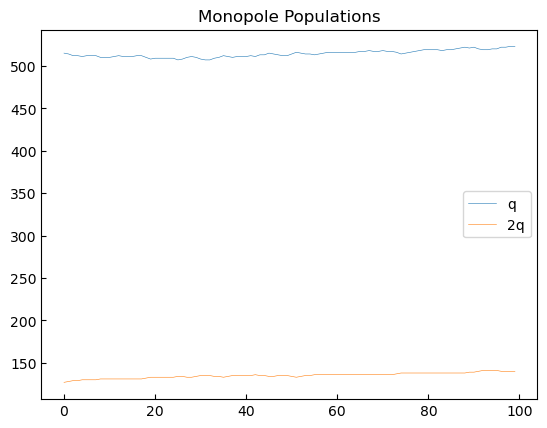

In [102]:
N_burn = 100
time0 = time.time()
states, energies, times = kmc(states[-1, :,:,:,:], N_burn, T = 1.0*np.ones(N_burn),mode="two-rate"); winsound.Beep(600, 200);
# states, energies = mmc(states[-1, :,:,:,:], Nn, T = T_array, loops=True); winsound.Beep(600, 200);
print("That took " +str(time.time() - time0)+" seconds.")
plot(energies - min(energies), linewidth=0.3)
show()
monopole_population = np.zeros((N_burn, 5), dtype = int)
for d in range(0, N_burn):
    monopole_population[d, :] = calc_monopole_population(states[d, :,:,:,:])
for i in range(3, 5):
    if i != 2:# and i != 1 and i != 3:
        plot(monopole_population[:,i], linewidth=0.4)
legend(["q", "2q"])
# plot(monopole_population[:,2], linewidth=0.4)
title("Monopole Populations")
show()

In [80]:
# rates_n = sorted(list(random.rand(Nx*Ny*Nz*Nmu)))
rates_n = random.rand(Nx*Ny*Nz*Nmu)
# for nu in arange(Nx*Ny*Nz*Nmu-1, -1, -1):  # Cumulation and Escape Rate  (Step 4)
#     rates_n[nu] = sum(rates_n[:nu])        # Reverse order cumulation, so there's no unwriting
rates_n = np.cumsum(rates_n)
Qk = rates_n[-1]

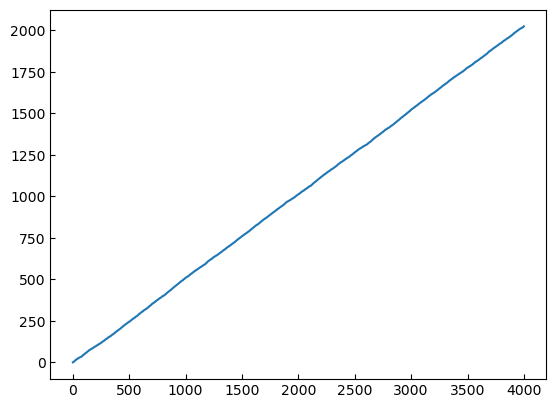

In [81]:
plot(rates_n)

In [ ]:
N_epoch = 10
N_step = 100000
# temperature = np.arange(1.5, 0.0, -1.5/(N_epoch*N_step))
temperature = np.zeros(N_epoch*N_step)
# high temp
temperature[: 1*N_step] = np.arange(10.0, 3.0, -7.0/(1*N_step))[:1*N_step]
# mid temp
temperature[1*N_step : 3*N_step] = np.arange(3.0, 1.2, -1.8/(3*N_step))[:2*N_step]
# low temp
temperature[3*N_step :] = np.arange(1.2, 0.0, -1.2/((N_epoch-3)*N_step))[:7*N_step]


date = "Oct 26"
save("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_temperature.npy", temperature)

last_time = 0.0
for n in arange(1, N_epoch):
    print(n, temperature[n*N_step])
    states, energies, times = kmc(states[-1, :,:,:,:], N_step, T = temperature[n*N_step:(n+1)*N_step]); winsound.Beep(600, 200);
    save("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_states"+str(n)+".npy", states)
    save("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_energies"+str(n)+".npy", energies)
    save("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_times"+str(n)+".npy", times+last_time*np.ones(N_step+1)); last_time = times[-1];
    
    monopole_population = np.zeros((N_step, 5), dtype = int)
    for d in range(0, N_step):
        monopole_population[d, :] = calc_monopole_population(states[d, :,:,:,:])
    save("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_monopole_population"+str(n)+".npy", monopole_population)
    save("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_magnetization"+str(n)+".npy", calc_mag(states, np.zeros((N_step, 3))))
    
    plot((energies)); ylabel("Energy (K)"); show();   #[K]    #*10**6*8.617333*10**-5) #[microeV]
    plot(monopole_population[:,3]); ylabel("Monopole Population"); show();

In [ ]:
# Repackage the data
# Nx = 10; Ny = 10; Nz = 10; Nmu = 4;
N_epoch = 30; N_steps = 100000; Nd = N_epoch*N_steps;
states = np.zeros((N_epoch*N_steps, Nx, Ny, Nz, Nmu), dtype=int8)
energies = np.zeros(N_epoch*N_steps)
times = np.zeros(N_epoch*N_steps)
monopole_population = np.zeros((N_epoch*N_steps, 5), dtype=int)
magnetization = np.zeros((N_epoch*N_steps, 3))
date = "Nov 2"

for n in range(0,N_epoch):
    states[n*N_steps:(n+1)*N_steps, :,:,:,:] = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_states"+str(n)+".npy")[:N_steps,:,:,:,:]
    energies[n*N_steps:(n+1)*N_steps] = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_energies"+str(n)+".npy")[:N_steps]
    times[n*N_steps:(n+1)*N_steps] = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_times"+str(n)+".npy")[:N_steps]
    monopole_population[n*N_steps:(n+1)*N_steps,:] = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_monopole_population"+str(n)+".npy")[:N_steps,:]
    magnetization[n*N_steps:(n+1)*N_steps,:] = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_magnetization"+str(n)+".npy")[:N_steps,:]
    
save("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_states.npy", states)
save("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_energies.npy", energies)
save("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_times.npy", times)
save("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_monopoles.npy", monopole_population)
save("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_magnetization.npy", magnetization)

<h5>Recompute Time</h5>

In [ ]:
states = (2.0*(np.random.randint(0,2,(1000,Nx,Ny,Nz,Nmu)) - 0.5)).astype(int8)

In [ ]:
nns = array(list(zip(*where(eta_J1!=0))))

In [ ]:
nns.shape

In [43]:
local_axis

array([[-0.57735027, -0.57735027, -0.57735027],
       [-0.57735027,  0.57735027,  0.57735027],
       [ 0.57735027, -0.57735027,  0.57735027],
       [ 0.57735027,  0.57735027, -0.57735027]])

In [52]:
sum(np.multiply.outer(sum((states[0,:,:,:,:]*where(eta_J1!=0, 1, 0)),tuple([4,5,6,7])), local_axis),4).shape

(10, 10, 10, 4, 3)

In [60]:
# @jit
def calc_effective_field_old(state):
    effective_field = np.zeros((Nx, Ny, Nz, Nmu, 3))
    for xi, yi, zi, mui, xj, yj, zj, muj in list(zip(*where(eta_J1!=0))):
        effective_field[xi,yi,zi,mui, :] += state[xj,yj,zj,muj]*local_axis[muj]
    return effective_field
# @jit
def calc_effective_field(state):
    return sum(np.multiply.outer(sum((state*where(eta_J1!=0, 1, 0)),tuple([4,5,6,7])), local_axis),3)

In [61]:
time0 = time.time()
for n in range(0,10):
    test = calc_effective_field(states[n, :,:,:,:])
print(time.time()-time0)
    
time0 = time.time()
for n in range(0,10):
    test2 = calc_effective_field_old(states[n, :,:,:,:])
print(time.time()-time0)
print(where(test!=test2))

1.9642531871795654
3.8451457023620605
(array([0, 0, 0, ..., 9, 9, 9], dtype=int64), array([0, 0, 0, ..., 9, 9, 9], dtype=int64), array([0, 0, 0, ..., 9, 9, 9], dtype=int64), array([0, 0, 0, ..., 3, 3, 3], dtype=int64), array([0, 1, 2, ..., 0, 1, 2], dtype=int64))


In [55]:
test

array([[[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0.,

In [ ]:
renew_times = np.zeros(3000000, dtype=float64)                                        # Initial time for Simulation (Step 1)

time0 = time.time()
for n in arange(1,3000000):
    ### Reporting
    if n % 1000 == 0:
        print("That took "+str(time.time()-time0)+"seconds.", "About "+str(((3000000-n)/3000000)*time.time()-time0)+" seconds remaining.")
        time0 = time.time()
        if n % 250000 == 0:
            show(plot(times))
    ### Reporting
            
    rates_n = flatten_state(rates_mask(calc_rates(states[n, :,:,:,:], temperature[n]), states[n, :,:,:,:]))
    Qk = sum(array(rates_n))
    dt = (Qk**-1)*log(1/random.rand())
    renew_times[n] = renew_times[n-1] + dt       # Increment time by dt

In [64]:
where(temperature<1.2)

(array([ 500001,  500002,  500003, ..., 2999997, 2999998, 2999999],
       dtype=int64),)

In [ ]:
[temperature[a] for a in range(0,2000000,250000)]

In [91]:
log(exp(1.2456))

1.2456

C:\Users\kakor\AppData\Local\Temp\ipykernel_12808\1829229617.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  new_times[n:n+100000] *= mean1/mean2
C:\Users\kakor\AppData\Local\Temp\ipykernel_12808\1829229617.py:20: RuntimeWarning: invalid value encountered in add
  new_times[n:] += new_times[n-1] - new_times[n]                # Shift
C:\Users\kakor\AppData\Local\Temp\ipykernel_12808\1829229617.py:16: RuntimeWarning: invalid value encountered in subtract
  mean2 = mean(new_times[n+6001:n+20001]-new_times[n:n+14000])/6000.0
C:\Users\kakor\AppData\Local\Temp\ipykernel_12808\1829229617.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  new_times1[n:n+100000] *= mean11/mean21
C:\Users\kakor\AppData\Local\Temp\ipykernel_12808\1829229617.py:19: RuntimeWarning: invalid value encountered in add
  new_times1[n:] += new_times1[n-1] - new_times1[n]                # Shift
C:\Users\kakor\AppData\Local\Temp\ipykernel_12808\1829229617.py:12: RuntimeWarning: inva

NameError: name 'dt1_smooth' is not defined

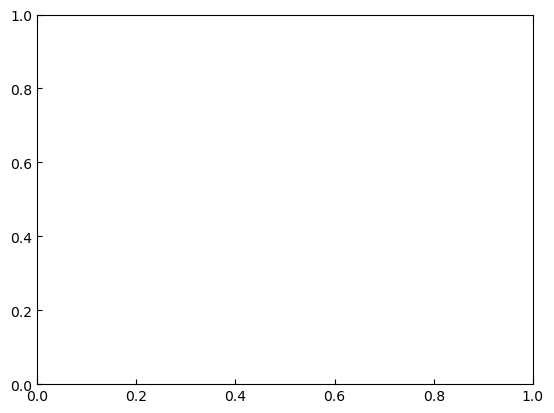

In [103]:
date = "Nov 2"
temperature1 = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_temperature.npy")
times1 = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_times.npy")
date = "Nov 2_2"
temperature = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_temperature.npy")
times = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_times.npy")

new_times1 = deepcopy(times1).astype(float64)
new_times = deepcopy(times).astype(float64)
for n in range(200000, 3000000, 100000):
    mean11 = mean(new_times1[n-10002:n-1]-new_times1[n-10003:n-2]) # Remove individual scaling
    mean21 = mean(new_times1[n+6001:n+20001]-new_times1[n:n+14000])/6000.0
    new_times1[n:n+100000] *= mean11/mean21
   
    mean1 = mean(new_times[n-10002:n-1]-new_times[n-10003:n-2]) # Remove individual scaling
    mean2 = mean(new_times[n+6001:n+20001]-new_times[n:n+14000])/6000.0
    new_times[n:n+100000] *= mean1/mean2
    
    new_times1[n:] += new_times1[n-1] - new_times1[n]                # Shift
    new_times[n:] += new_times[n-1] - new_times[n]                # Shift
    
    mean31 = mean(new_times1[200001:500001]-new_times1[200000:500000]) # Scale to seconds [Davis 3 to 1.2 K]
    new_times1 *= (83 * 10 **-6)/mean31
    mean3 = mean(new_times[200001:500001]-new_times[200000:500000]) # Scale to seconds [Davis 3 to 1.2 K]
    new_times *= (83 * 10 **-6)/mean3

# dt = new_times[1:]-new_times[0:-1]; dt1 = new_times1[1:]-new_times1[0:-1];
# dt_smooth = np.zeros(3000000); dt1_smooth = np.zeros(3000000); counts = np.zeros(3000000);
# for n in range(5000,2995000):
#     dt_smooth[n-5000:n+5000] += dt[n]
#     dt1_smooth[n-5000:n+5000] += dt1[n]
#     counts[n-5000:n+5000] += 1

# dt_smooth /= counts; dt1_smooth /= counts
                     
fig, ax = subplots()
ax.plot( ((log(dt1_smooth))*temperature)[500000:], linewidth=0.3)
ax.plot( ((log(dt_smooth))*temperature)[500000:], linewidth=0.3)
ax.plot( (log(np.exp(4.5/temperature))*temperature)[500000:1897000])
# ax.set_ylabel("Time (Hours)")
ax.set_xlabel("Inverse Temperature (1/Kelvin)")
# ax.set_xticks([0, 250000, 500000, 750000, 1000000, 1250000, 1500000, 1750000, 2000000, 2250000, 2500000])
# ax.set_xticklabels([str(round(temperature[a],1)) for a in range(0,2750000,250000)])

ax.set_xticks([0, 250000, 500000, 750000, 1000000, 1250000, 1500000, 1750000, 2000000])
ax.set_xticklabels(["1/"+str(round(temperature[a],1)) for a in range(500000,2750000,250000)])

legend(["KMC", "Two-Rate KMC", "\u221d exp(4.5K/T)"])
# print(new_times[199996:200004])
# plot(new_times[199996:200004])

In [ ]:
np.exp(4.5*np.ones(3000000)/temperature)[:1750000]

In [111]:
date = "Nov 2"
temperature1 = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_temperature.npy")
renew_times1 = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_renew_times.npy")
mean31 = mean(renew_times1[200001:500001]-renew_times1[200000:500000]) # Scale to seconds [Davis 3 to 1.2 K]
renew_times1 *= (83 * 10 **-6)/mean31
date = "Nov 2_2"
temperature = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_temperature.npy")
renew_times = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_renew_times.npy")
mean3 = mean(renew_times[200001:500001]-renew_times[200000:500000]) # Scale to seconds [Davis 3 to 1.2 K]
renew_times *= (83 * 10 **-6)/mean3

dt1 = renew_times1[1:]-renew_times1[0:-1];
dt1_smooth = np.zeros(3000000); counts = np.zeros(3000000);
dt = renew_times[1:]-renew_times[0:-1]; dt_smooth = np.zeros(3000000);
for n in range(5000,2995000):
    dt1_smooth[n-5000:n+5000] += dt1[n]
    dt_smooth[n-5000:n+5000] += dt[n]
    counts[n-5000:n+5000] += 1
dt1_smooth /= counts
dt_smooth /= counts

C:\Users\kakor\AppData\Local\Temp\ipykernel_10016\2620995359.py:12: RuntimeWarning: invalid value encountered in subtract
  dt1 = renew_times1[1:]-renew_times1[0:-1];
C:\Users\kakor\AppData\Local\Temp\ipykernel_10016\2620995359.py:14: RuntimeWarning: invalid value encountered in subtract
  dt = renew_times[1:]-renew_times[0:-1]; dt_smooth = np.zeros(3000000);
C:\Users\kakor\AppData\Local\Temp\ipykernel_10016\2620995359.py:19: RuntimeWarning: invalid value encountered in true_divide
  dt1_smooth /= counts
C:\Users\kakor\AppData\Local\Temp\ipykernel_10016\2620995359.py:20: RuntimeWarning: invalid value encountered in true_divide
  dt_smooth /= counts


In [201]:
renew_times

array([0.00000000e+00, 3.83103245e-05, 1.04903206e-04, ...,
                  inf,            inf,            inf])

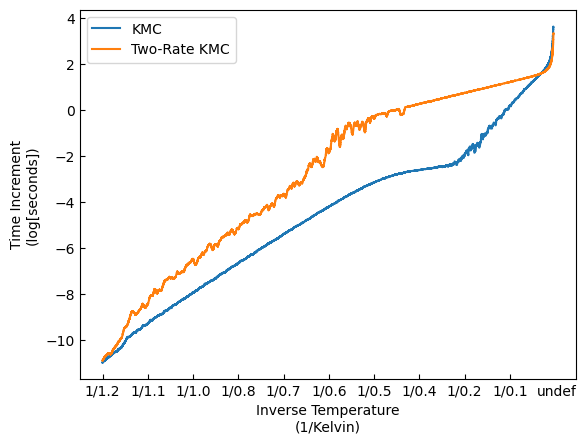

In [105]:
fig, ax = subplots()
ax.plot((log(dt1_smooth)*temperature)[500000:])
ax.plot((log(dt_smooth)*temperature)[500000:])
# dl = 3.0*np.exp(4.5/temperature)[1:] - 3.0*np.exp(4.5/temperature)[0:-1]
# ax.plot((log(dl)*temperature[:2999999])[500000:], alpha=0.5)
ax.set_xticks([0, 250000, 500000, 750000, 1000000, 1250000, 1500000, 1750000, 2000000, 2250000])
ax.set_xticklabels(["1/"+str(round(temperature[a],1)) for a in range(500000,2999999,250000)])
ax.set_xlabel("Inverse Temperature\n(1/Kelvin)")
ax.set_ylabel("Time Increment\n(log[seconds])")
text(2400000, -12.42, 'undef')
legend(["KMC", "Two-Rate KMC", "\u221d exp(4.5K/T)"])

In [235]:
temperature[2500000]

0.24000000006121236

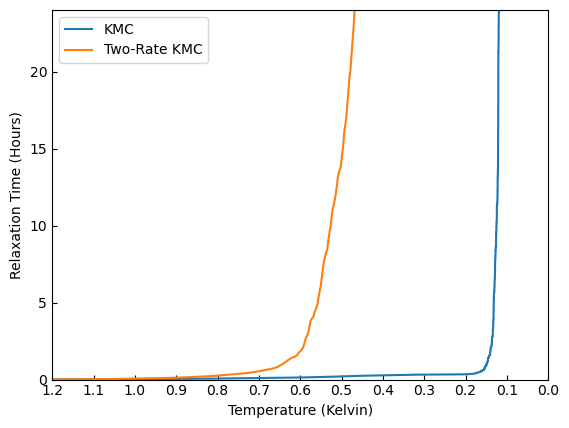

In [124]:
fig, ax = subplots()
ax.plot(temperature[500000:], (renew_times1)[500000:]/3600)
ax.plot(temperature[500000:], renew_times[500000:]/3600)
# ax.plot(2.5*np.exp(4.5/temperature)[500000:2700000])
# ax.set_xticks([0, 250000, 500000, 750000, 1000000, 1250000, 1500000, 1750000, 2000000, 2250000])
# ax.set_xticklabels([str(round(temperature[a],1)) for a in range(500000,2999999,250000)])
ax.set_xlabel("Temperature (Kelvin)")
ax.set_ylabel("Relaxation Time (Hours)")
ax.set_xticks(arange(1.2, -0.05, -0.1))
ax.set_xlim(1.2, 0.0)
ax.set_ylim(0, 24)
legend(["KMC", "Two-Rate KMC", "\u221d exp(4.5K/T)"])

<h5>Magnetization Noise</h5>

In [288]:
date="Nov 2_2"
energy = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_energies.npy")
temperature = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_temperature.npy")
magnetization = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_magnetization.npy")
renew_times = load("K:/code/spin ice/"+date+"/pyrochlore-spin-ice_renew_times.npy")
mean3 = mean(renew_times[200001:500001]-renew_times[200000:500000]) # Scale to seconds [Davis 3 to 1.2 K]
renew_times *= (83 * 10 **-6)/mean3

Text(0.5, 0, 'Time (s)')

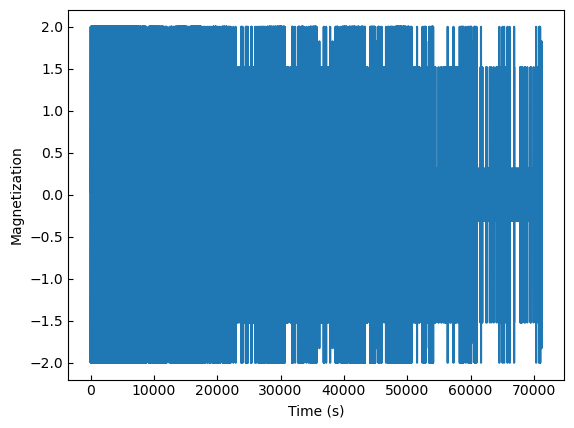

In [445]:
mag = sum(magnetization*magnetization, 1)**0.5
plot(renew_times[200000:2000000], mag[200001:2000001]-mag[200000:2000000])
ylabel("Magnetization")
xlabel("Time (s)")

This magnetization treats each time step the same. I need to sample the magnetization by the kmc time.

In [325]:
where(temperature<1.2)

(array([ 500001,  500002,  500003, ..., 2999997, 2999998, 2999999],
       dtype=int64),)

In [331]:
where(renew_times[200000:] > 0*sample_inc)[0][0]

0

In [350]:
renew_times[1750000]

6607.824112266765

In [346]:
10000*10**-5

0.1

1.0355587200104852  K


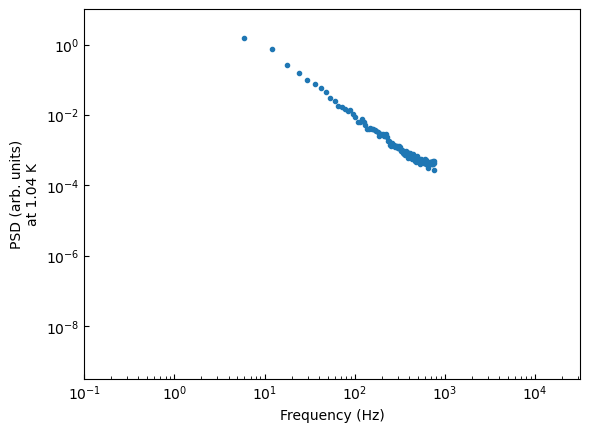

In [125]:
from scipy import signal
temp = 1.04
sample_length = 10000; sample_start = where(temperature < temp)[0][0]
sample = np.zeros(sample_length)
sample_inc = (renew_times[sample_start+1000] - renew_times[sample_start])/1000 #83*10**-6
for n in range(sample_length):
    sample[n] = mag[where(renew_times[sample_start:] > n*sample_inc+renew_times[sample_start])[0][0]+sample_start]
print(temperature[where(renew_times[sample_start:] > n*sample_inc+renew_times[sample_start])[0][0]+sample_start]," K")

psd = signal.welch(sample-mean(sample), sample_inc**-1)
loglog(psd[0], psd[1], ".")
ylabel("PSD (arb. units)\nat "+str(temp)+" K")
xlabel("Frequency (Hz)")
ylim(10**-9.5, 10**1)
xlim(10**-1, 10**4.5);show()

In [161]:
def colecoleform(x, A, tau, alpha):
    return A/(1 + (2*np.pi*x*tau)**alpha)

In [127]:
popt, pcov = scipy.optimize.curve_fit(colecoleform, psd[0], psd[1], p0=[1.0, 83*10**-6, 1.5],
                                     bounds=[[0.0,0.0,0.0],[np.inf,np.inf,2.0]])
A, tau, alpha = popt
print(popt,"\n",pcov)

[0.97521846 0.01021607 2.        ] 
 [[ 6.06896886e-03  8.24642583e-05 -1.11486281e-02]
 [ 8.24642583e-05  2.16569284e-06 -2.96191427e-04]
 [-1.11486281e-02 -2.96191427e-04  1.05843881e-01]]


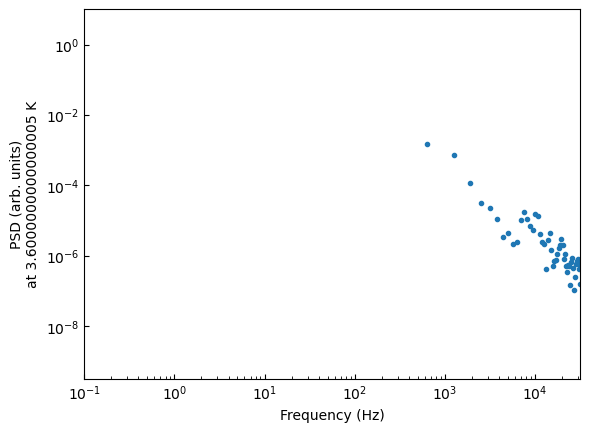

In [170]:
psd = signal.welch(sample, sample_inc**-1)
loglog(psd[0], psd[1], ".")
loglog(psd[0], colecoleform(psd[0], A, tau, alpha), linewidth=0.5)
ylabel("PSD (arb. units)\nat "+str(temp)+" K")
xlabel("Frequency (Hz)")
ylim(10**-9.5, 10**1)
xlim(10**-1, 10**4.5);show()

Let's make a plot of alpha.

[8.32716073e-04 6.18865755e-12 1.60000000e+00] 
 [[7.54253672e-10 8.45257975e-05 0.00000000e+00]
 [8.45257975e-05 1.53958083e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[0.97054665 0.00537044 1.6       ] 
 [[ 2.95390115e-02  2.47807463e-04 -3.50128360e-02]
 [ 2.47807463e-04  3.77984963e-06 -6.12886592e-04]
 [-3.50128360e-02 -6.12886592e-04  2.26375944e-01]]
[1.23589593 0.00363439 1.6       ] 
 [[ 5.33023244e-02  2.33948922e-04 -4.71000492e-02]
 [ 2.33948922e-04  1.97204338e-06 -4.67237079e-04]
 [-4.71000492e-02 -4.67237079e-04  2.63693038e-01]]
[1.02196104 0.00318506 1.6       ] 
 [[ 2.78122607e-02  1.30732114e-04 -3.07588307e-02]
 [ 1.30732114e-04  1.13829938e-06 -3.09881940e-04]
 [-3.07588307e-02 -3.09881940e-04  1.95190716e-01]]
[1.25640741e-02 3.58537427e-04 1.60000000e+00] 
 [[ 7.60674488e-06  3.30195907e-07 -7.04504842e-04]
 [ 3.30195907e-07  2.57479657e-08 -6.27228709e-05]
 [-7.04504842e-04 -6.27228709e-05  3.44499932e-01]]


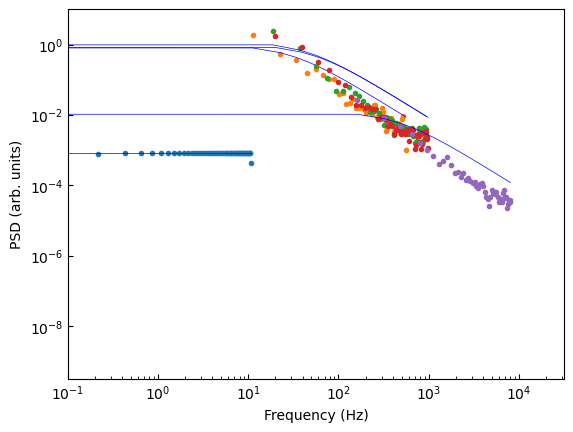

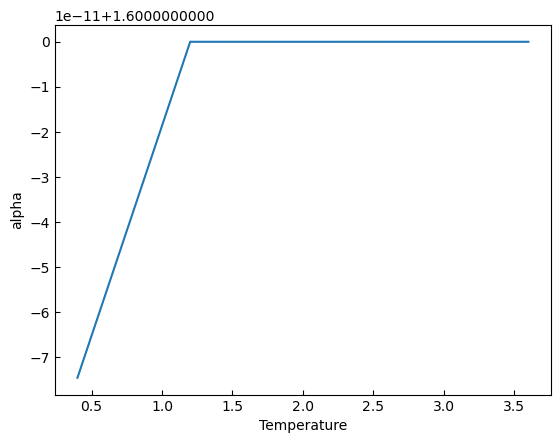

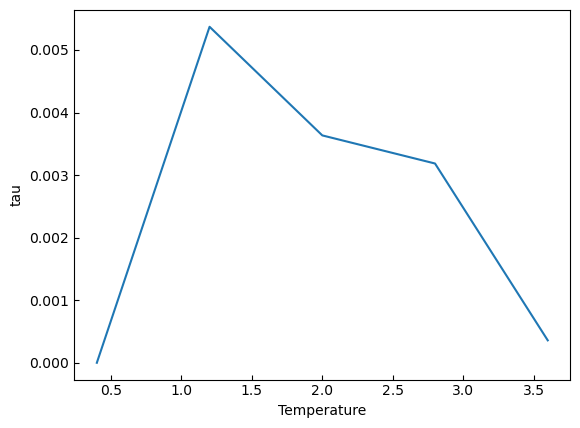

In [175]:
alphas = np.zeros(5)
taus = np.zeros(5)
for temp in arange(0.4, 4.0, 0.8):
    sample_length = 500; sample_start = where(temperature < temp)[0][0]
    sample = np.zeros(sample_length)
    sample_inc = (renew_times[sample_start+1] - renew_times[sample_start])*10.0 #83*10**-6
    for n in range(sample_length):
        sample[n] = mag[where(renew_times[sample_start:] > n*sample_inc+renew_times[sample_start])[0][0]+sample_start]
    
    psd = signal.welch(sample, sample_inc**-1, nperseg=100)
    
    popt, pcov = scipy.optimize.curve_fit(colecoleform, psd[0], psd[1], p0=[1.0, 0.0, 1.2],
                                     bounds=[[0.0,0.0,0.9],[np.inf,np.inf,1.6]])
    A, tau, alpha = popt
    print(popt,"\n",pcov)
    alphas[int(round((temp-0.4)/0.8))] = alpha
    taus[int(round((temp-0.4)/0.8))] = tau
    
    loglog(psd[0], psd[1], ".")
    loglog(psd[0], colecoleform(psd[0], A, tau, alpha), linewidth=0.5,c='b')
    ylabel("PSD (arb. units)")#\nat "+str(round(temp,1))+" K")
    xlabel("Frequency (Hz)")
    ylim(10**-9.5, 10**1)
    xlim(10**-1, 10**4.5)
# legend(["0.4K", "0.4K fit"...
show()
plot(arange(0.4, 4.0, 0.8), alphas)
ylabel("alpha")
xlabel("Temperature")
show()
plot(arange(0.4, 4.0, 0.8), taus)
ylabel("tau")
xlabel("Temperature")
show()

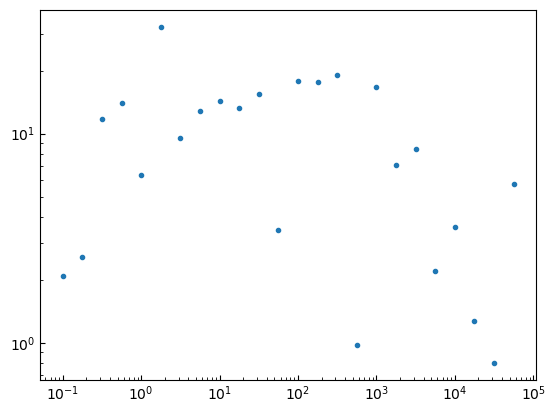

In [42]:
psd = signal.lombscargle(renew_times[2100000:2500000], mag[2100000:2500000], [10**lam for lam in arange(-1, 5.0, 0.25)])
loglog([10**lam for lam in arange(-1, 5.0, 0.25)], psd, ".")

In [25]:
mag[1100000:1120000]

array([18.58314649, 19.18332609, 19.14854216, ..., 10.06644591,
       10.51982256, 12.4365054 ])

In [739]:
magnetization[1:,:]# - magnetization[:-1,:]

array([[-2.66453526e-15, -4.15692194e+01, -4.61880215e+00],
       [-1.15470054e+00, -4.27239199e+01, -3.46410162e+00],
       [-2.30940108e+00, -4.38786205e+01, -2.30940108e+00],
       ...,
       [-2.30940108e+00, -2.30940108e+00, -2.30940108e+00],
       [-1.15470054e+00, -1.15470054e+00, -1.15470054e+00],
       [-2.30940108e+00, -2.30940108e+00, -2.30940108e+00]])

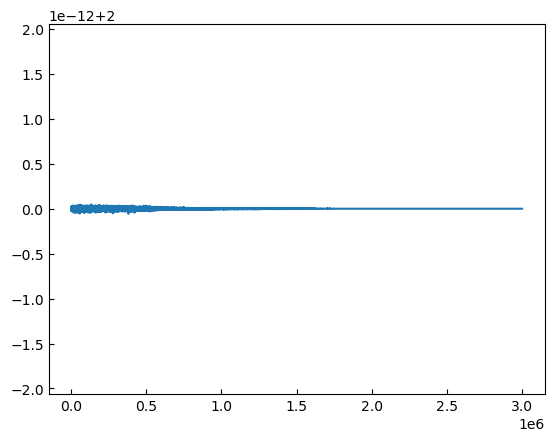

In [737]:
dm = magnetization[1:,:] - magnetization[:-1,:]
mag_noise = sum(dm*dm,1)**0.5
plot(mag_noise); show()

In [748]:
psd.shape

(6000,)

In [614]:
def colecoleform(x, A, tau, alpha, C):
    return (A/(1 + (2*np.pi*x*tau)**alpha)) + C

In [1002]:
def gaussian(x, A=1.0):
    sig = x.shape[0]/1000
    return A*exp(-(x**2)/sig**2)
# plot(gaussian(arange(-45000, 45000, 1)))

In [1023]:
# @jit
def moving_average(x, halfwidth = 500):
    x_smooth = np.zeros(x.shape[0])
    counts = np.zeros(x.shape[0])
    for i in range(halfwidth, x.shape[0]-halfwidth):
        x_smooth[i-halfwidth:i+halfwidth+1] += x[i]
        counts[i-halfwidth:i+halfwidth+1] += 1
    return x_smooth / counts

In [1008]:
temps = arange(0.65, 3.0, 0.5)
alphas = np.zeros(temps.shape[0])
taus = np.zeros(temps.shape[0]); c = 0
for temp in temps:
    sample_length = 90000; sample_freq = arange(1e-1, 1e2, 0.1)#np.array([10**lam for lam in arange(-2.0, 4.0, 0.25)])
    sample_start = where(temperature < temp)[0][0]
    mag2 = gaussian(arange(-int(round(sample_length/2)),int(round(sample_length/2)),1))*(abs(magnetization[sample_start-int(round(sample_length/2)):sample_start+int(round(sample_length/2)),0])+abs(magnetization[sample_start-int(round(sample_length/2)):sample_start+int(round(sample_length/2)),1]) + abs(magnetization[sample_start-int(round(sample_length/2)):sample_start+int(round(sample_length/2)),2]))
#     plot(mag2); show()
    dm = magnetization[1+sample_start-int(round(sample_length/2)):1+sample_start+int(round(sample_length/2)),:] - magnetization[sample_start-int(round(sample_length/2)):sample_start+int(round(sample_length/2)),:]
    mag_noise = sum(dm*dm,1)**0.5
#     plot(mag_noise);show()
    
    psd = signal.lombscargle(renew_times[sample_start-int(round(sample_length/2)):sample_start+int(round(sample_length/2))],
                             mag2,
                             sample_freq, normalize=False, precenter=True)

    popt, pcov = scipy.optimize.curve_fit(colecoleform, sample_freq.astype(double), psd.astype(double),
                                          p0=[(mean(psd)), (renew_times[sample_start+100]-renew_times[sample_start-100])/200, 1.45, 0],
                                          bounds=[[0, 0, 1, 0],[1e7, 1e0, 2, 1e4]],
                                          maxfev=10000, ftol = 1e-11, xtol = 1e-15,
                                          method='dogbox', loss='cauchy', verbose=0, x_scale='jac')#[1e3, 1e-2, 1e-1, 1e1])
    # print(mean(psd[:100]),mean(psd[-100:]))
    A, tau, alpha, C = popt
    alphas[c] = alpha
    taus[c] = tau; c += 1
    print(popt)#, "\n",pcov)

    loglog(sample_freq, psd, ".")
    loglog(sample_freq, colecoleform(sample_freq, A, tau, alpha, C), linewidth=0.5,c='b')
    ylabel("PSD (arb. units)")#\nat "+str(round(temp,1))+" K")
    xlabel("Frequency (Hz)")
#     legend(["1K", "1K Fit ("+str(alphas[0])+")", "8dK", "8dK Fit ("+str(alphas[1])+")", "6dK", "6dK Fit ("+str(alphas[2])+")"])
show()
plot(temps, alphas); show()
plot(temps, taus); show()


KeyboardInterrupt



In [1014]:
psd.shape

(581,)

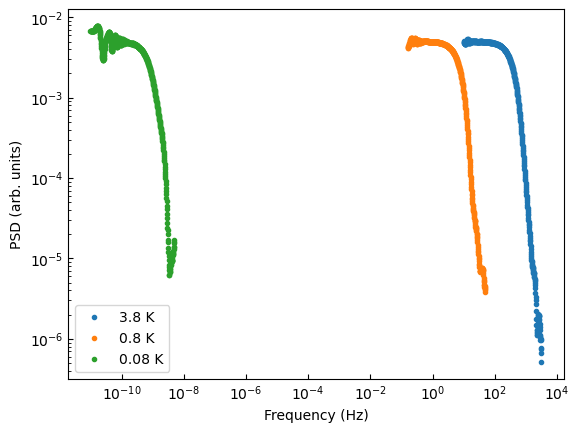

In [1030]:
for temp in [3.8, 0.8, 0.08]:
    sample_length = 50000
#     sample_freq = np.array([10**lam for lam in arange(-1.0, 4.0, 0.005)])
    if temp == 3.8:
        sample_freq = np.array([10**lam for lam in arange(1.0, 3.5, 0.005)])
    if temp == 0.8:
        sample_freq = np.array([10**lam for lam in arange(-0.8, 1.7, 0.005)])
    if temp == 0.08:
        sample_freq = np.array([10**lam for lam in arange(-11.0, -8.3, 0.005)])
    sample_start = where(temperature < temp)[0][0]
    dm = magnetization[1+sample_start-int(round(sample_length/2)):1+sample_start+int(round(sample_length/2)),:] - magnetization[sample_start-int(round(sample_length/2)):sample_start+int(round(sample_length/2)),:]
    mag_noise = gaussian(arange(-int(round(sample_length/2)),int(round(sample_length/2)),1))*sum(dm*dm,1)**0.5

    psd = signal.lombscargle(renew_times[sample_start-int(round(sample_length/2)):sample_start+int(round(sample_length/2))],
                             mag_noise,
                             sample_freq, normalize=True, precenter=True)

    loglog(sample_freq, moving_average(psd,5), ".")
    ylabel("PSD (arb. units)")
    xlabel("Frequency (Hz)")
    legend(["3.8 K", "0.8 K", "0.08 K"])
show()

In [ ]:
1.04 [6.15291871e+04 2.09807331e-02 1.57546025e+00 6.79603851e+01]
0.84 [8.57085835e+03 4.29175624e-02 1.41974078e+00 4.15885595e+01]

C:\Users\kakor\AppData\Local\Temp\ipykernel_10016\510279528.py:2: RuntimeWarning: invalid value encountered in power
  return A/(1 + (2*np.pi*x*tau)**alpha)
C:\Users\kakor\AppData\Local\Temp\ipykernel_10016\510279528.py:2: RuntimeWarning: invalid value encountered in power
  return A/(1 + (2*np.pi*x*tau)**alpha)
C:\Users\kakor\AppData\Local\Temp\ipykernel_10016\510279528.py:2: RuntimeWarning: invalid value encountered in power
  return A/(1 + (2*np.pi*x*tau)**alpha)


[2.82449371e-04 1.47314345e-02 1.99999965e+00]
[1.43714444e-04 1.93678640e-03 1.99626758e+00]
[1.45413815e-04 1.67312790e-03 1.99996063e+00]


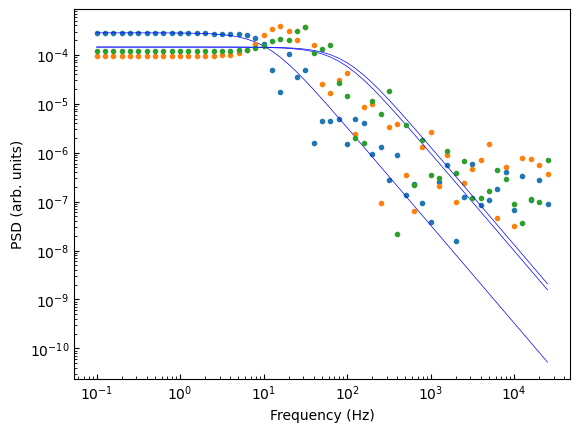

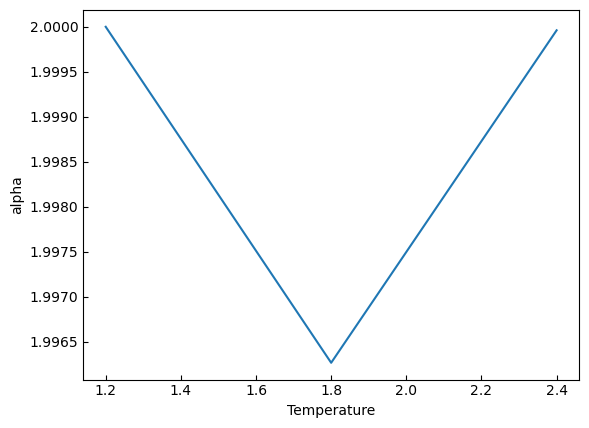

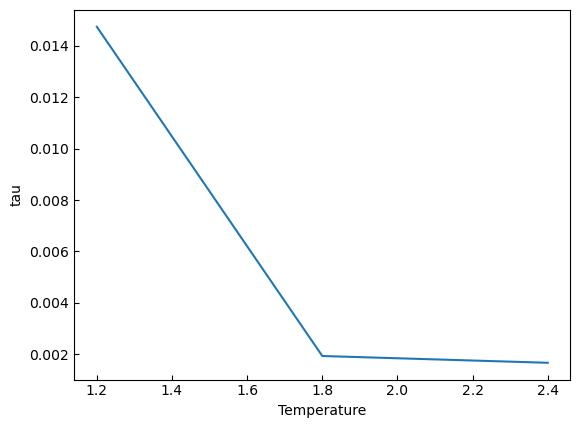

In [103]:
alphas = np.zeros(3)
taus = np.zeros(3)
sample_length = 5000; sample_freq = np.array([10**lam for lam in arange(-1, 4.5, 0.1)])
for temp in arange(1.2, 2.5, 0.6):
    sample_start = where(temperature < temp)[0][0]
    
    psd = signal.lombscargle(renew_times[sample_start-int(round(sample_length/2)):sample_start+int(round(sample_length/2))],
                             energy[sample_start-int(round(sample_length/2)):sample_start+int(round(sample_length/2))],
                             sample_freq, normalize=True, precenter=True)
    
    popt, pcov = scipy.optimize.curve_fit(colecoleform, sample_freq, psd, p0=[1.0, 1.0, 1.2],
                                          bounds=[[-np.inf,-np.inf,0.5],[np.inf,np.inf,2.0]])
    A, tau, alpha = popt
    print(popt)#,"\n",pcov)
    alphas[int(round((temp-1.2)/0.6))] = alpha
    taus[int(round((temp-1.2)/0.6))] = tau
    
    loglog(sample_freq, psd, ".")
    loglog(sample_freq, colecoleform(sample_freq, A, tau, alpha), linewidth=0.5,c='b')
    ylabel("PSD (arb. units)")#\nat "+str(round(temp,1))+" K")
    xlabel("Frequency (Hz)")
#     ylim(10**-9.5, 10**1)
#     xlim(10**-1, 10**4.5)
# legend(["0.4K", "0.4K fit"...
show()
plot(arange(1.2, 2.5, 0.6), alphas)
ylabel("alpha")
xlabel("Temperature")
show()
plot(arange(1.2, 2.5, 0.6), taus)
ylabel("tau")
xlabel("Temperature")
show()

<h5> Heat Capacity </h5>

In [ ]:
states_sdev = deepcopy(states) #np.ones((10000,Nx,Ny,Nz,Nmu))

In [ ]:
# sdev(E) Calculation for Heat Capacity
Nn =  1000;
sdev_pack = [] # [[Temp, sdev], n]
for Ti in arange(0.5, 50.0, 0.5):
    T_array = Ti*ones(Nn)

    # Simulate
    states_sdev, energies_sdev = mmc(states_sdev[-1, :,:,:,:], Nn, T_array, loops=True)

    sdev_pack.append(array([Ti, round(std(energies_sdev[int(round(0.7*Nn))::100]),3), energies_sdev[int(round(0.7*Nn))::500]]))

In [ ]:
N_T = sdev_pack[7][2].shape[0]
T = np.zeros(N_T)
sdev = np.zeros(N_T)
E_list = np.zeros((N_T,10))
for n in range(0,N_T):
    T[n] = sdev_pack[n][0]
    sdev[n] = sdev_pack[n][1]
    E_list[n,:] = sdev_pack[n][2][:10]

In [ ]:
plot(T[:], (sdev[:]**2)/(T[:]**3))
title("C/T with T")
xlabel("T [K]")
ylabel("C/T [J mol**-1 K**-2]")
ylabel("sdev(E)**2/T**2")
show()

In [ ]:
ent = np.zeros(N_T) # Ramirez 1999 Fig
ent[0] = 0.25*(sdev[0]**2)/(T[0]**3)/N
for n in arange(0, N_T, +1):
        ent[n] = 0.25*(sdev[n]**2)/(T[n]**3)/N + ent[n-1]
plot(ent)
plot(log(2)*np.ones(N_T))
plot((log(2)-0.5*log(3/2))*np.ones(N_T))
show()

<h5>Plot the System</h5>

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 
sites = realspace.reshape(Nx*Ny*Nz*Nmu,3)
sigma = states[9990,:,:,:,:].reshape(Nx*Ny*Nz*Nmu)
local_axis = spin_orient.reshape(Nx*Ny*Nz*Nmu,3)
spins = array([ sigma[:] * local_axis[:,0], sigma[:] * local_axis[:,1], sigma[:] * local_axis[:,2] ])
tetrahedra = array([ d[0], d[1], d[2], d[3], d[1], d[2], d[0], d[3], d[0], -d[1], -d[2], -d[3], -d[1], -d[2], d[0], -d[3] ])
for i in range(0,Nx):
    for j in range(0,Ny):
        for k in range(0,Nz):
            if (i == 0 and j == 0) or (j == 0 and k == 0) or (k == 0 and i == 0):
                tetrahedra_ijk = deepcopy(tetrahedra[:9])
            else:
                tetrahedra_ijk = deepcopy(tetrahedra)
            for t in range(0,tetrahedra_ijk.shape[0]):
                tetrahedra_ijk[t,:] = realspace[i,j,k,0,:]+tetrahedra[t,:]
            ax.plot(tetrahedra_ijk[:,0], tetrahedra_ijk[:,1], tetrahedra_ijk[:,2], color='grey',linestyle='solid',alpha=0.2)
ax.scatter(sites[:,0], sites[:,1], sites[:,2], s = 2,color='k')
ax.quiver(sites[:,0], sites[:,1], sites[:,2], spins[0,:], spins[1,:], spins[2,:], length=0.1, normalize=True)
plt.show()

<h5>Energy Autocorrellation</h5>

In [ ]:
from scipy.optimize import curve_fit
E = 2.7182818

In [ ]:
def decay(x, a, b, c):
    y = zeros(x.shape)
    for n in arange(0,x.shape[0]):
        y[n] = a*E**(b*x[n]) + c
    return y

In [ ]:
unit_energy = energies/dot(energies,energies)**0.5

In [ ]:
autocorrelation = zeros(700)
for n in arange(0,700):
    autocorrelation[n] = corrcoef(unit_energy[n:],unit_energy[:(1001-n)])[0,1]

popt, pcov = curve_fit(decay,arange(0,200),autocorrelation[:200],array([1.0,-1.0,0.0]))
print(popt)
    
show( plot(arange(0,700),decay(arange(0,700),popt[0],popt[1],popt[2]),autocorrelation[:700]) )

In [ ]:
tau = -popt[1]**-1; print(tau);

This number is the physical correlation time in spin ice. To obtain statistically orthogonal samples, I must ensure that they are at least this distant.

In [ ]:
states = load("K:/code/spin ice/freeze - Aug 11/pyrochlore-spin-ice_quench_state.npy")
energies = load("K:/code/spin ice/freeze - Aug 11/pyrochlore-spin-ice_quench_energy.npy")

In [ ]:
test_energies = np.zeros(energies.shape[0])
for n in range(energies.shape[0]):
    if n % 100000 == 0:
        print(n)
    test_energies[n] = calc_energy(states[n, :,:,:,:])

In [ ]:
# plot(temperature, energies)
plot(temperature, test_energies)
xlim(0.5, 0.0)
show()

In [1031]:
test = ['a','b','c']
for i,p in enumerate(test):
    print(i,p)

0 a
1 b
2 c
